## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [38]:
import pandas as pd
import numpy as np

In [39]:
#load the original dataframe

file_name="data_000637.txt"
data=pd.read_csv(file_name)
data        

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [40]:
# 1) Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. 
#    Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

N = 11000
df = data[:N]
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
10995,1,0,139,3869200277,204,0
10996,1,0,61,3869200277,202,20
10997,1,0,63,3869200277,204,1
10998,1,0,59,3869200277,283,29


In [41]:
# 2) Find out the number of BX in a ORBIT (the value 'x').

x = max(df['BX_COUNTER'])
print('number of BX in one ORBIT:',x)

number of BX in one ORBIT: 3563


In [42]:
# 3) Find out how much the data taking lasted. 
#    You can either make an estimate based on the fraction of the measurements (rows) you read, 
#    or perform this check precisely by reading out the whole dataset.

num_orb = max(data['ORBIT_CNT']) - min(data['ORBIT_CNT'])-1    #the 1st and the last orb are not completed
tot_orb = num_orb*max(data['BX_COUNTER'])*25*10**-9            #sec for the completed orbits

# BX remaning from uncompleted orbits
bx_1st_orb = max(data['BX_COUNTER']) - data['BX_COUNTER'][0]   #bx for the 1st orbit
bx_last_orb = data['BX_COUNTER'][1310720-1]                    #bx for the last orbit
bx_rest = (bx_1st_orb + bx_last_orb)*25*10**-9

# TDC remaning from uncompleted BX
tdc_rest = (data['TDC_MEAS'][0]+data['TDC_MEAS'][1310720-1])*(25/30)*10**-9

total_time = tot_orb + bx_rest + tdc_rest 
print('data acquisition time:', (total_time), 'sec')

data acquisition time: 0.9801410366666667 sec


In [43]:
# 4) Create a new column with the absolute time in ns 
#    (as a combination of the other three columns with timing information).

df['ABS_TIME (sec)'] = ( df['TDC_MEAS']*25/30 + df['BX_COUNTER']*25 + 
                      (df['ORBIT_CNT']-df['ORBIT_CNT'][0])*max(df['BX_COUNTER'])*25)*10**-9 

df['ABS_TIME (sec)'] = df['ABS_TIME (sec)'] - df['ABS_TIME (sec)'][0]
df


<ipython-input-43-ec3482d3ebbe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ABS_TIME (sec)'] = ( df['TDC_MEAS']*25/30 + df['BX_COUNTER']*25 +
<ipython-input-43-ec3482d3ebbe>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ABS_TIME (sec)'] = df['ABS_TIME (sec)'] - df['ABS_TIME (sec)'][0]


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME (sec)
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.333333e-10
2,1,0,63,3869200167,2553,28,4.476667e-06
3,1,0,64,3869200167,2558,19,4.594167e-06
4,1,0,64,3869200167,2760,25,9.649167e-06
...,...,...,...,...,...,...,...
10995,1,0,139,3869200277,204,0,9.743978e-03
10996,1,0,61,3869200277,202,20,9.743945e-03
10997,1,0,63,3869200277,204,1,9.743979e-03
10998,1,0,59,3869200277,283,29,9.745977e-03


In [44]:
# 5) Replace the values (all 1) of the HEAD column randomly with 0 or 1.
import random

for i in range(len(df['HEAD'])):
    df['HEAD'][i] = random.randint(0,1)

df

<ipython-input-44-331aedc458b7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HEAD'][i] = random.randint(0,1)
C:\Users\hp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME (sec)
0,0,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.333333e-10
2,1,0,63,3869200167,2553,28,4.476667e-06
3,0,0,64,3869200167,2558,19,4.594167e-06
4,1,0,64,3869200167,2760,25,9.649167e-06
...,...,...,...,...,...,...,...
10995,0,0,139,3869200277,204,0,9.743978e-03
10996,1,0,61,3869200277,202,20,9.743945e-03
10997,1,0,63,3869200277,204,1,9.743979e-03
10998,1,0,59,3869200277,283,29,9.745977e-03


In [45]:
# 6) Create a new DataFrame that contains only the rows with HEAD=1
new_D = df[df['HEAD'] == 1]
new_D

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME (sec)
1,1,0,124,3869200167,2374,27,8.333333e-10
2,1,0,63,3869200167,2553,28,4.476667e-06
4,1,0,64,3869200167,2760,25,9.649167e-06
6,1,0,61,3869200167,2772,14,9.940000e-06
8,1,0,62,3869200167,2774,21,9.995833e-06
...,...,...,...,...,...,...,...
10992,1,0,63,3869200277,193,12,9.743713e-03
10996,1,0,61,3869200277,202,20,9.743945e-03
10997,1,0,63,3869200277,204,1,9.743979e-03
10998,1,0,59,3869200277,283,29,9.745977e-03


Text(0, 0.5, 'counts')

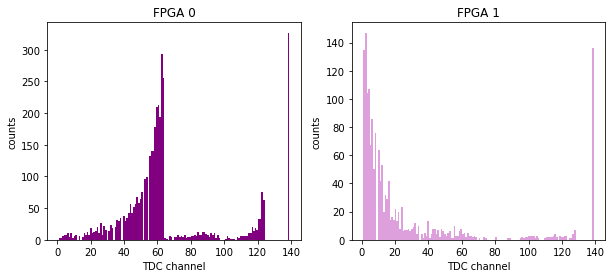

In [46]:
# 7) Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel
import matplotlib.pyplot as plt
%matplotlib inline

# 2 new dataframe, sorted by FPGA
df0 = new_D[new_D['FPGA'] == 0]
df1 = new_D[new_D['FPGA'] == 1]

# histo
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax1.hist(df0['TDC_CHANNEL'], bins = 140, color = 'purple')
ax1.set_title('FPGA 0')
ax1.set_xlabel('TDC channel')
ax1.set_ylabel('counts')

ax2.hist(df1['TDC_CHANNEL'], bins = 140, color = 'plum')
ax2.set_title('FPGA 1')
ax2.set_xlabel('TDC channel')
ax2.set_ylabel('counts')



In [47]:
# 8) Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

# the DataFrame from which the data are taken is new_D, so the one with HEAD = 1.
# summing up all its rows, HEAD gives the frequency of each TDC channels

# FPGA 0
TDC_0 = df0.groupby(['TDC_CHANNEL']).sum()  
TDC_0.nlargest(3,'HEAD')
#print('the TDC channels with most counts (for FPGA 0) are:', TDC_0.nlargest(3,'HEAD').index)

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME (sec)
TDC_CHANNEL,,,,,,
139,327,0,1265228472302,567975,0,1.570789
63,293,0,1133675665222,517264,4350,1.446660
64,255,0,986646057369,482134,3711,1.313801


In [48]:
# FPGA 1
TDC_1 = df1.groupby('TDC_CHANNEL').sum()
TDC_1.nlargest(3,'HEAD')
#print('the TDC channels with most counts (for FPGA 1) are:', TDC_1.nlargest(3,'HEAD').index)

,HEAD,FPGA,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME (sec)
TDC_CHANNEL,,,,,,
2,147,147,568772432741,278786,2061,0.727946
139,136,136,526211230266,258210,0,0.671253
1,135,135,522342030046,256898,1851,0.666560


In [49]:
# 9) Count the number of unique orbits. 
#    Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

new_D

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME (sec)
1,1,0,124,3869200167,2374,27,8.333333e-10
2,1,0,63,3869200167,2553,28,4.476667e-06
4,1,0,64,3869200167,2760,25,9.649167e-06
6,1,0,61,3869200167,2772,14,9.940000e-06
8,1,0,62,3869200167,2774,21,9.995833e-06
...,...,...,...,...,...,...,...
10992,1,0,63,3869200277,193,12,9.743713e-03
10996,1,0,61,3869200277,202,20,9.743945e-03
10997,1,0,63,3869200277,204,1,9.743979e-03
10998,1,0,59,3869200277,283,29,9.745977e-03


In [50]:
#number of different orbits in this dataframe 
new_D['ORBIT_CNT'].nunique()             #same as : max(new_D['ORBIT_CNT']) - min(new_D['ORBIT_CNT'])

111

In [51]:
#number of different orbits in this dataframe with at least one count in channel 139
new_D[new_D['TDC_CHANNEL']==139]['ORBIT_CNT'].nunique()

108